<a href="https://colab.research.google.com/github/LiNdA-jz/cifar10_ann_to_snn/blob/main/cifar10_ann_to_snn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install snntoolbox

     |████████████████████████████████| 203 kB 4.1 MB/s 


170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 15s 6ms/step - loss: 1.2700 - accuracy: 0.5476 - val_loss: 1.1530 - val_accuracy: 0.5778
Epoch 2/100
782/782 [==============================] - 4s 6ms/step - loss: 0.8694 - accuracy: 0.6975 - val_loss: 0.9690 - val_accuracy: 0.6721
Epoch 3/100
782/782 [==============================] - 4s 6ms/step - loss: 0.6900 - accuracy: 0.7591 - val_loss: 1.0108 - val_accuracy: 0.6566
Epoch 4/100
782/782 [==============================] - 5s 6ms/step - loss: 0.5499 - accuracy: 0.8076 - val_loss: 1.0744 - val_accuracy: 0.6778
Epoch 5/100
782/782 [==============================] - 4s 6ms/step - loss: 0.4264 - accuracy: 0.8493 - val_loss: 1.0676 - val_accuracy: 0.6864
Epoch 6/100
782/782 [==============================] - 4s 6ms/step - loss: 0.3212 - accuracy: 0.8883 - val_loss: 1.0032 - val_accuracy: 0.7211
Epoch 7/100
782/782 [==============================] - 4s 6ms/step - loss: 0.2340 - accuracy: 0.9193 - val_loss: 1.1756 - val_accuracy: 0.7149
Epoch 8/10

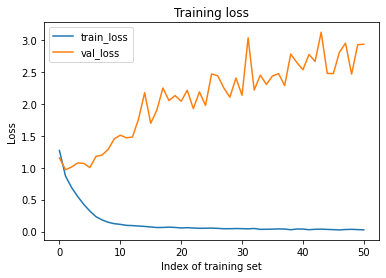

In [2]:
"""End-to-end example for SNN Toolbox.

This script sets up a small CNN using Keras and tensorflow, trains it for one
epoch on MNIST, stores model and dataset in a temporary folder on disk, creates
a configuration file for SNN toolbox, and finally calls the main function of
SNN toolbox to convert the trained ANN to an SNN and run it using INI
simulator.
"""

import os
import time
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Input, Model, datasets, layers, models
from tensorflow.keras.utils import to_categorical

from snntoolbox.bin.run import main
from snntoolbox.utils.utils import import_configparser

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping

# WORKING DIRECTORY #
#####################

# Define path where model and output files will be stored.
# The user is responsible for cleaning up this temporary directory.
# path_wd = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath(
#     __file__)), 'temp', str(time.time())))
path_wd = "gdrive/MyDrive/30040/output/" + str(time.time())
os.makedirs(path_wd)

# GET DATASET #
###############

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Save dataset so SNN toolbox can find it.
np.savez_compressed(os.path.join(path_wd, 'x_test'), x_test)
np.savez_compressed(os.path.join(path_wd, 'y_test'), y_test)
# SNN toolbox will not do any training, but we save a subset of the training
# set so the toolbox can use it when normalizing the network parameters.
np.savez_compressed(os.path.join(path_wd, 'x_norm'), x_train[::10])

# ANN
model = models.Sequential()
# dimension of output, kernel size
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

axis = 1 if keras.backend.image_data_format() == 'channels_first' else -1
# pool size
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization(axis=axis))

model.summary()

# dense takes 1D vector
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(64))
# model.add(layers.ReLU())
# CIFAR has 10 classes
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# early stopping callback if no improvement in loss
es = EarlyStopping(monitor='loss', 
                    mode='max', # don't minimize the accuracy!
                    patience=50,
                    restore_best_weights=True)

model_fit = model.fit(x_train, y_train, batch_size=64, epochs=100, 
                    validation_data=(x_test, y_test),
                    callbacks=[es])

# plot graph for loss
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epoch = range(0,len(model_fit.history['loss']),1)
plt.figure()
plt.plot()
plt.plot(epoch, train_loss, label='train_loss')
plt.plot(epoch, val_loss, label='val_loss')
plt.legend()
plt.title('Training loss')
plt.xlabel('Index of training set')
plt.ylabel('Loss')
plt.show()

# Store model so SNN Toolbox can find it.
model_name = 'cifar10_cnn'
keras.models.save_model(model, os.path.join(path_wd, model_name + '.h5'))



In [3]:
!pip install brian2

     |████████████████████████████████| 1.5 MB 3.9 MB/s 


In [ ]:
# path_wd = '/content/gdrive/MyDrive/30040/output/1639674077.1328545'

# model_name = 'cifar10_cnn'

# SNN TOOLBOX CONFIGURATION #
#############################

# Create a config file with experimental setup for SNN Toolbox.
configparser = import_configparser()
config = configparser.ConfigParser()

config['paths'] = {
    'path_wd': path_wd,             # Path to model.
    'dataset_path': path_wd,        # Path to dataset.
    'filename_ann': model_name      # Name of input model.
}

config['input'] = {
    # 'model_lib': 'keras',
    'poisson_input': True          # Images are encodes as spike trains.
}

config['tools'] = {
    'evaluateAnn': True,            # Test ANN on dataset before conversion.
    # 'parse': True,
    'normalize': True               # Normalize weights for full dynamic range.
    # 'convert': True
}

config['normalization'] = {
    'percentile': 99.9,
    'normalization_schedule': True
}

# config['conversion'] = {
#     # 'softmax_to_relu': True,
#     'maxpool_type': 'avg_max',
#     'spike_code': 'ttfs_dyn_thresh'
# }

config['simulation'] = {
    'simulator': 'brian2',          # Chooses execution backend of SNN toolbox.
    'duration': 50,                 # Number of time steps to run each sample.
    'dt': 0.1,                      # Time resolution for ODE solving.
    'num_to_test': 100,             # How many test samples to run.
    'batch_size': 1,                # Batch size for simulation.
    'top_k': 5
}

config['cell'] = {
    'v_thresh': 0.6,
    'reset': 'Reset by subtraction'    
}

config['output'] = {
    'plot_vars': {                  # Various plots (slows down simulation).
        'activations',
        'spiketrains',              # Leave section empty to turn off plots.
        'spikerates',
        'error_t',
        'correlation',
        # 'v_mem',
        }
}

# Store config file.
config_filepath = os.path.join(path_wd, 'config')
with open(config_filepath, 'w') as configfile:
    config.write(configfile)

# RUN SNN TOOLBOX #
###################

main(config_filepath)


Initializing brian2 simulator...

Loading data set from '.npz' files in /content/gdrive/MyDrive/30040/output/1644586270.689319.



WARNING    /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
 [py.warnings]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                    

WARNING    /usr/local/lib/python3.7/dist-packages/snntoolbox/simulation/utils.py:1828: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])
 [py.warnings]


Top-1 accuracy: 40.00%
Top-5 accuracy: 85.00%

Building spiking model...
Building layer: 00Conv2D_30x30x32
Transposing kernels.
................................
Connecting layer...
Building layer: 01Conv2D_28x28x32
Transposing kernels.
................................
Connecting layer...


WARNING    /usr/local/lib/python3.7/dist-packages/snntoolbox/simulation/utils.py:1479: RuntimeWarning: Layer type 'MaxPooling' not supported yet. Falling back on 'AveragePooling'.
  "Falling back on 'AveragePooling'.", RuntimeWarning)
 [py.warnings]


Streaming output truncated to the last 5000 lines.
Done.

Resetting simulator...

Starting new simulation...

Starting simulation at t=0. s for a duration of 50. ms
0.4 ms (0%) simulated in < 1s, estimated 2s remaining.
0.6 ms (1%) simulated in < 1s, estimated 2s remaining.
0.8 ms (1%) simulated in < 1s, estimated 3s remaining.
0.9 ms (1%) simulated in < 1s, estimated 3s remaining.
1.1 ms (2%) simulated in < 1s, estimated 3s remaining.
1.2 ms (2%) simulated in < 1s, estimated 4s remaining.
1.3 ms (2%) simulated in < 1s, estimated 4s remaining.
1.4 ms (2%) simulated in < 1s, estimated 4s remaining.
1.5 ms (3%) simulated in < 1s, estimated 5s remaining.
1.6 ms (3%) simulated in < 1s, estimated 5s remaining.
1.7 ms (3%) simulated in < 1s, estimated 5s remaining.
1.8 ms (3%) simulated in < 1s, estimated 6s remaining.
1.9 ms (3%) simulated in < 1s, estimated 6s remaining.
2. ms (4%) simulated in < 1s, estimated 6s remaining.
2.1 ms (4%) simulated in < 1s, estimated 6s remaining.
2.2 ms (4%)